# **Performing A/B Test for the dataset ab_data.csv**

## **Table of Contents**

*  Introduction
*  Importing Libraries
*  Reading Dataset
*  Data Preprocessing
*  A/B Test

## **Introduction**

A/B tests are very commonly performed by data analysts and data scientists. 
In this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

## **Importing essential libraries**

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(42) # to give the same results everytime

## **Reading the Dataset**

In [2]:
# reading the csv file using pandas
df = pd.read_csv('/content/ab_data.csv')

Information about the dataset

In [3]:
# top 5 rows of the dataframe
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# column names of the dataframe
df.columns.to_list()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

In [5]:
# shape of the dataframe
df.shape

(294478, 5)

## **Data Preprocessing**

Checking for missing values

In [6]:
# checking for any null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Data types of the columns

In [7]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

Number of times the **new_page** and **treatment** is not lined up

In [8]:
# no. of times the new_page and treatment is not lined up is equal to
not_linedup_1 = df.query("group == 'treatment' and landing_page == 'old_page'").count()
not_linedup_2 = df.query("group == 'control' and landing_page == 'new_page'").count()
print(not_linedup_1 + not_linedup_2)

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64


Eliminating those rows where the **group** is not lined up with the **landing_page** as we only want to give **new_page** to the **control** group.

In [9]:
# storing the aligned data in another dataframe
df2 = df.query("(group=='treatment' and landing_page=='new_page') or (group=='control' and landing_page=='old_page')")

In [10]:
# top 5 rows of the new dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# shape
df2.shape

(290585, 5)

In [12]:
# how many number of 0's and 1's
df2.converted.value_counts()

0    255832
1     34753
Name: converted, dtype: int64

Number of unique users

In [13]:
df['user_id'].nunique()

290584

Number of duplicated users

In [14]:
df2['user_id'].duplicated().sum()

1

Eliminating the duplicated row

In [15]:
# displaying the duplicated rows
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# removing the second row
df2.drop_duplicates(subset=['user_id'], inplace = True)
df2['user_id'].duplicated().sum()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0

## **A/B Test**

### **Background Information to help you better understand the results :**



In this case, we will take the difference of conversion rates of the pages as the metric of our A/B Testing.

We will calculate p-value, if p-value is really small, less likely to observe the statistic in the null , more likely from the alternative.
p-value is large you will end up staying with the null hypothesis as your choice.

Type 1 error threshold is alpha

*  If p < alpha , reject the null , choose H1
*  If p > alpha , fail to reject the null, choose H0


1. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses be

*  H0 : p(new)-p(old) <= 0 old has better conversion

*  H1 : p(new)-p(old) > 0 new has better conversion

where **p(new)** and **p(old)** are the conversion rates.

2. Assume under the null hypothesis, and both have "true" success rates equal to the converted success rate regardless of page - that is and are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

**Steps:**



1.   Compute the observed difference between the metric, p_new for treatment group and p_old for control group.
2.   Simulate the sampling distribution for the difference of the conversion rate.
3.   Use this sampling distribution to simulate the distribution under null hypothesis, by creating a random normal distribution centered at 0 with the same size and spread.
4.   Compute the p-value by finding the difference of the conversion rates from the null distribution that are greater than our observed difference.
5.   Use this p-value to determine the statistical significance of our observed difference.



### **Step-1: Observed statistic**

Observed Difference is equal to the difference between new conversion rate and old conversion rate.

In [17]:
# number of unique users accessing old page
N_old = df2.query("landing_page =='old_page'")['user_id'].nunique()
N_old

145274

In [18]:
# number of unique users accessing new page
N_new = df2.query("landing_page =='new_page'")['user_id'].nunique()
N_new

145310

In [19]:
# compute actual conversion rate
# number of landing new page and converted  / number of landing new page
converted_new = df2.query('converted == 1 and landing_page== "new_page"')['user_id'].nunique()
actual_new = float(converted_new) / float(N_new)

# number of landing old page and converted  / number of landing old page
converted_old = df2.query('converted == 1 and landing_page== "old_page"')['user_id'].nunique()
actual_old = float(converted_old) / float(N_old)

#observed difference in converted rate
obs_diff = actual_new - actual_old
obs_diff

-0.0015782389853555567

But does this result statistically significant? We check it by calculating the p-value.

### **Step-2: Simulating sampling distribution**

In [20]:
# top 5 rows of the dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Under null hypothesis, both the conversion rates of new_page and old_page are the same. They are equal to the converted rate regardless of the page.

In [21]:
p_new = p_old = round(float(df2.query('converted==1').user_id.nunique()) / float(df2.shape[0]), 4)
print(p_new,' ',p_old)

0.1196   0.1196


In [22]:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):
  sample = df2.sample(size, replace = True)
  old_conversion = np.random.choice(sample['converted'], N_old, (p_old,1-p_old))
  new_conversion = np.random.choice(sample['converted'], N_new, (p_new,1-p_new))
  p_diffs.append(new_conversion.mean() - old_conversion.mean())

p_diffs = np.array(p_diffs)

### **Step-3: Simulating the random normal distribution**

Generating normal distribution under null hypothesis using numpy library with zero mean and size and spread same as the samples.

In [23]:
null_values = np.random.normal(0, p_diffs.std(), p_diffs.size)

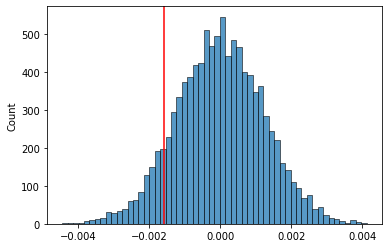

In [24]:
sns.histplot(null_values)
plt.axvline(x=obs_diff,color ='red')
plt.show()

### **Step-4 : Calculating p-value**

In [25]:
# as the test is a right tailed test
p_value = (null_values > obs_diff).mean()
p_value

0.8977

### **Step-5: Determining the statistical significance**

The p-value we got from the A/B testing is greater than the significance level (>0.05) which concludes that there is no enough evidence to reject the null hypothesis.

We fail to reject the null. Therefore, the data show, with a Type I error rate of 0.05, that the old page has higher probablity of conversion rate than new page.

## **Conclusion**

From the statistical result we got by performing A/B Test on the dataset we have, we can conclude that the company should keep their old page.